ctrl shift alt enter: debug

In [18]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def torch_fix_seed(seed=42):
    """ 乱数シードを固定
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()

# 学習データセットの準備

In [49]:
# 初期条件: x∈[-1,0], y∈[-1,0], t=0のとき，u=-sin(x), v=-sin(y)
n_initial = 500
t_initial = np.zeros(n_initial) 
x_initial = (np.random.random(n_initial) - 0.5) * 2 
y_initial = (np.random.random(n_initial) - 0.5) * 2 

u_initial = np.ones(n_initial)
v_initial = np.ones(n_initial)
for i in range(n_initial):
    if (x_initial[i]<0)&(y_initial[i]<0) :
        u_initial[i] = -1 * np.sin(np.pi * x_initial[i]) + 1
        v_initial[i] = -1 * np.sin(np.pi * y_initial[i]) + 1

# 境界条件: 壁面で(u, v)=(1, 1)
n_boundary = 250
t_boundary = np.random.random(n_boundary*2)
x_boundary_h = np.random.choice([-1, 1], n_boundary)
y_boundary_h = (np.random.random(n_boundary) - 0.5) * 2
x_boundary_v = (np.random.random(n_boundary) - 0.5) * 2
y_boundary_v = np.random.choice([-1, 1], n_boundary)
x_boundary = np.block([x_boundary_h, x_boundary_v])
y_boundary = np.block([y_boundary_h, y_boundary_v])
 
u_boundary = np.ones(n_boundary*2)
v_boundary = np.ones(n_boundary*2)

# 支配方程式の残差を評価する計算領域内の座標
n_region = 10000
t_region = np.random.random(n_region)
x_region = (np.random.random(n_region) - 0.5) * 2
y_region = (np.random.random(n_region) - 0.5) * 2 


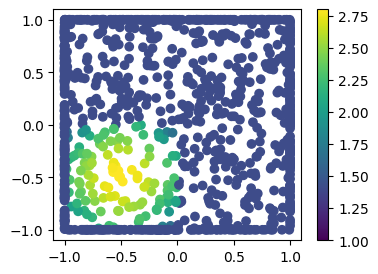

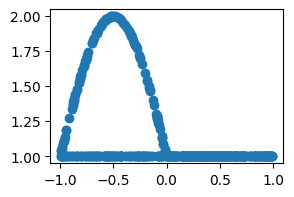

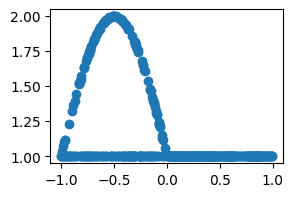

In [45]:
# 可視化
plt.figure(figsize=(4, 3))
plt.scatter(x_initial, y_initial, c=np.sqrt(u_initial**2+v_initial**2), vmin=1, vmax=2.8)
plt.scatter(x_boundary, y_boundary, c=np.sqrt(u_boundary**2+v_boundary**2), vmin=1, vmax=2.8)
plt.colorbar()
plt.show()

plt.figure(figsize=(3, 2))
plt.scatter(x_initial, u_initial)
plt.show()

plt.figure(figsize=(3, 2))
plt.scatter(y_initial, v_initial)
plt.show()

# ネットワークの構築

In [46]:
class NN(nn.Module):
    def __init__(self, n_input, n_output, n_hiddens=[32,64,128,128,64,32]):
        
        super(NN, self).__init__()
        
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(n_input, n_hiddens[0])
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(n_hiddens[i], n_hiddens[i+1]) for i in range(len(n_hiddens)-1)]
        )
        self.output_layer = nn.Linear(n_hiddens[-1], n_output)
        
        
    def forward(self, x):
        
        x = self.activation(self.input_layer(x))
        
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        
        x = self.output_layer(x)
        
        return x

In [47]:
class BurgersPINN():
    def __init__(self, model, nu):
        """ 
        """
        self.model = model
        self.nu = nu
        
        
    def net_u(self, x, t):
        """ 物理量を出力
        """
        u = self.model(torch.cat([x, t], dim=1))
        return u


    def net_f(self, X, t):
        """ 支配方程式との残差を出力
        """    
        # モデルが予測する物理量
        U_pred = self.net_u(X, t)
        
        u = U_pred[:, [0]]
        v = U_pred[:, [1]]
        
        # 微分係数を逆伝搬で計算
        du_dt = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0].T[0]
        dv_dt = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0].T[0]
        
        du_dx, du_dy = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0].T
        dv_dx, dv_dy = torch.autograd.grad(v, X, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0].T
        
        du_dxx, _ = torch.autograd.grad(du_dx, X, grad_outputs=torch.ones_like(du_dx), retain_graph=True, create_graph=True)[0].T
        _, du_dyy = torch.autograd.grad(du_dy, X, grad_outputs=torch.ones_like(du_dy), retain_graph=True, create_graph=True)[0].T
        dv_dxx, _ = torch.autograd.grad(dv_dx, X, grad_outputs=torch.ones_like(dv_dx), retain_graph=True, create_graph=True)[0].T
        _, dv_dyy = torch.autograd.grad(dv_dy, X, grad_outputs=torch.ones_like(dv_dy), retain_graph=True, create_graph=True)[0].T
        
        # 支配方程式に代入(f=0だと方程式と完全一致)
        fx = du_dt + u.T * du_dx + v.T * du_dy - self.nu * (du_dxx + du_dyy)
        fy = dv_dt + u.T * dv_dx + v.T * dv_dy - self.nu * (dv_dxx + dv_dyy)
        
        return (fx + fy).T
    
    
    def fit(self, X_bc, Y_bc, X_region, max_epochs=300, learning_rate=0.01, pi_weight=5e-4):
        """ 学習データでモデルを訓練
        """
        # 入力データをスライス
        t = X_bc[:, [0]]
        x = X_bc[:, [1,2]]
        u = Y_bc 
        t_region = X_region[:, [0]] 
        x_region = X_region[:, [1,2]]
        
        # 入力をtorch.tensorに変換
        t = torch.tensor(t, requires_grad=True).float()
        x = torch.tensor(x, requires_grad=True).float()
        u = torch.tensor(u, requires_grad=True).float()
        x_region = torch.tensor(x_region, requires_grad=True).float()
        t_region = torch.tensor(t_region, requires_grad=True).float()
        
        # 最適化ロジック
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # モデルを学習モードに変更
        self.model.train()
        
        # 学習
        history = []
        for epoch in range(max_epochs+1):
            
            # 現在のモデルで予測
            u_pred = self.net_u(x, t)
            f_pred = self.net_f(x_region, t_region)
            
            # 損失を計算
            loss_u = torch.mean((u - u_pred)**2)
            loss_pi = torch.mean(f_pred**2)
            loss_total = loss_u + loss_pi * pi_weight
            
            # 誤差逆伝搬
            loss_total.backward()
            
            # 最適化ソルバーで重みを動かす
            optimizer.step()
            
            # 最適化ソルバーの勾配情報を初期化
            optimizer.zero_grad()
            
            if epoch % 10 == 0:
                print(f'epoch:{epoch}, loss:{loss_total.item()}, loss_u:{loss_u.item()}, loss_pi:{loss_pi.item()}')
            
                history.append([epoch, loss_total.item(), loss_u.item(), loss_pi.item()])
        
        return np.array(history)
                
    def predict(self, X_in):
        """ モデルの予測
        """
        t = X_in[:, [0]]
        x = X_in[:, [1,2]]
        
        # 入力をtorch.tensorに変換
        x = torch.tensor(x, requires_grad=True).float()
        t = torch.tensor(t, requires_grad=True).float()
        
        self.model.eval()  # 評価モードに変更

        u = self.net_u(x, t).detach().numpy()
        f = self.net_f(x, t).detach().numpy()
        
        return u, f

In [48]:
# 学習用のデータ
X_bc = np.block([[t_initial, t_boundary], [x_initial, x_boundary], [y_initial, y_boundary]]).T
Y_bc = np.block([[u_initial, u_boundary], [v_initial, v_boundary]]).T
X_region = np.block([[t_region], [x_region], [y_region]]).T

print("shape:", X_bc.shape, Y_bc.shape, X_region.shape)

model = NN(3, 2)
pinn_model = BurgersPINN(model, nu=0.01)

# モデルを学習
history = pinn_model.fit(X_bc, Y_bc, X_region, max_epochs=1000, learning_rate=0.01, pi_weight=0.1)

shape: (1000, 3) (1000, 2) (10000, 3)
epoch:0, loss:1.4963371753692627, loss_u:1.496330976486206, loss_pi:6.228432903299108e-05
epoch:10, loss:0.0651128962635994, loss_u:0.06511015444993973, loss_pi:2.7386318834032863e-05
epoch:20, loss:0.05803756043314934, loss_u:0.058037545531988144, loss_pi:1.4576058049442508e-07
epoch:30, loss:0.05674345791339874, loss_u:0.05674343928694725, loss_pi:1.6925208967677463e-07
epoch:40, loss:0.05468256399035454, loss_u:0.05468253791332245, loss_pi:2.693038538836845e-07
epoch:50, loss:0.05436612293124199, loss_u:0.054366059601306915, loss_pi:6.231496740838338e-07
epoch:60, loss:0.05436279624700546, loss_u:0.05436256527900696, loss_pi:2.3164693629951216e-06
epoch:70, loss:0.05434156954288483, loss_u:0.05433676764369011, loss_pi:4.8033623897936195e-05
epoch:80, loss:0.05429860204458237, loss_u:0.054293036460876465, loss_pi:5.56463492102921e-05
epoch:90, loss:0.0542181134223938, loss_u:0.05419822037220001, loss_pi:0.00019893422722816467
epoch:100, loss:0.05

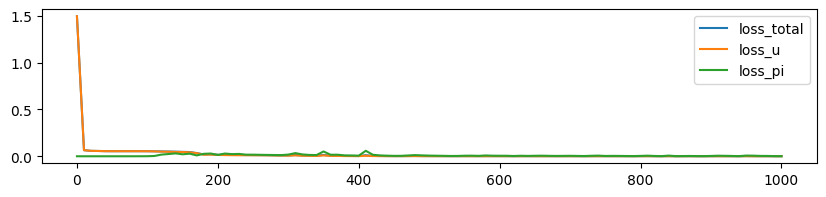

In [50]:
plt.figure(figsize=(10,2))
plt.plot(history[:, 0], history[:, 1], label='loss_total')
plt.plot(history[:, 0], history[:, 2], label='loss_u')
plt.plot(history[:, 0], history[:, 3], label='loss_pi')
plt.legend()

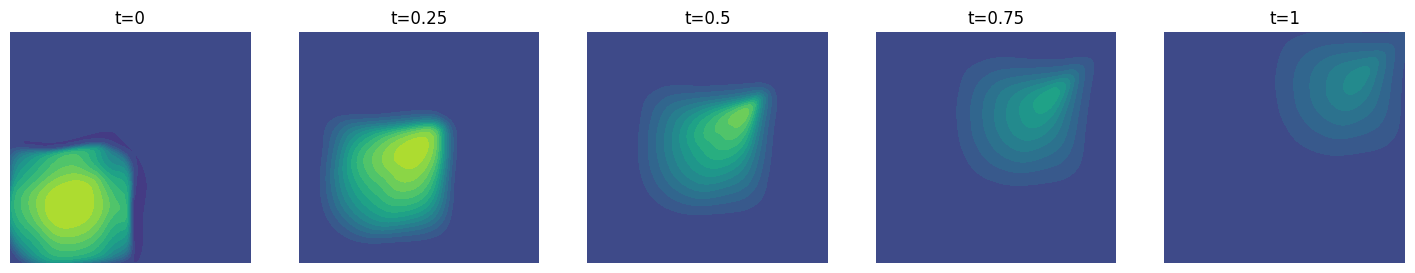

In [75]:
# 予測したいポイント
n = 100
x_pred = np.linspace(-1, 1, n)
y_pred = np.linspace(-1, 1, n)

x_grid, y_grid = np.meshgrid(x_pred, y_pred)

fig = plt.figure(figsize=(18, 3))

for i, t in enumerate([0, 0.25, 0.5, 0.75, 1]):
    t_pred = np.ones(n*n) * t
    X_in = np.block([[t_pred], [x_grid.flatten()], [y_grid.flatten()]]).T
    pred,_  = pinn_model.predict(X_in)

    u_pred = pred.reshape(n, n, 2)[:,:,0]
    v_pred = pred.reshape(n, n, 2)[:,:,1]

    # 物理量を可視化
    fig.add_subplot(1, 5, i+1)   
    plt.contourf(x_pred, y_pred, np.sqrt(u_pred**2+v_pred**2), np.linspace(1,3,21))
    plt.axis('off')
    plt.colorbar()
    plt.title(f't={t}')

plt.show()


In [ ]:
times = [0, 0.25, 0.5, 0.75]

fig = plt.figure(figsize=(15, 2))

for i, t in enumerate(times):
    t_pred = np.ones([100, 1]) * t
    X_in = np.column_stack([x_pred, t_pred])
    u_pred, f_pred = pinn_model.predict(X_in)
    
    fig.add_subplot(1, 4, i+1)    
    plt.plot(x_pred, u_pred, label='u_pred')
    plt.plot(x_pred, f_pred, label='f_pred')
    plt.ylim(-1.5, 1.5)
    plt.legend()
plt.show()
    